# Реализация логистической регрессии в TensorFlow

In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import contextlib
import sys

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

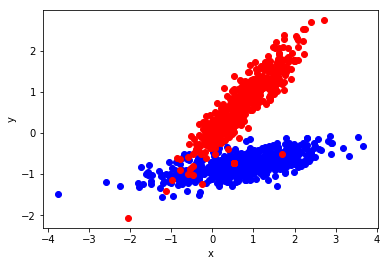

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [5]:
import random
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(random.choices(string.ascii_letters, k = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [6]:
def linear_op_forward(X, W, b):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T) + b # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    b = op.inputs[2] 
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    db = tf.reduce_sum(grads,axis = 0,keep_dims=True)
    return dX, dW, db

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1.0/(1.0 + np.exp(-X))

def sigmoid_op_backward(op, grads):
    # TODO: реализовать вычисление градиента для sigmoid
    X = op.inputs[0]
    sigmoid = lambda X: 1.0/(1.0 + tf.exp(-X))
    dX = tf.multiply(grads, sigmoid(X)*(1-sigmoid(X)))
    return dX

## Создание графа вычислений и обучение модели

In [32]:
# class DummyFile(object):
#     file = None
#     def __init__(self, file):
#         self.file = file

#     def write(self, x):
#     # Avoid print() second call (useless \n)
#         if len(x.rstrip()) > 0:
#             tqdm.write(x, file=self.file)

# @contextlib.contextmanager
# def nostdout():
#     save_stdout = sys.stdout
#     sys.stdout = DummyFile(sys.stdout)
#     yield
#     sys.stdout = save_stdout


In [ ]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    var_b = tf.Variable(tf.zeros(shape = [1,1],
                                dtype = tf.float32
                                  ))
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W, var_b],     # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)

    # кроссэнтропийная функция потерь для бмнарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.0005).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in tqdm(range(10000)):
#         with nostdout():
            # вначале каждой эпохи перемешиваем индексы
            np.random.shuffle(indices)

            # внутри каждой эпохи данные разбиваются на батчи
            for batch in range(len(X) // BATCH_SIZE):

                # выбираем индексы очередного батча
                batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

                # выполняем шаг обучения: вычисляем ошибку и обновляем веса
    #             print(y[batch_indices])
                loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                                   feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                                plh_labels: y[batch_indices]})

                # сохраняем занчения ошибки для построения кривой обучения
                learning_curve.append(loss)

                # выводим текущее значение ошибки для каждого 10го шага
                steps = len(learning_curve) - 1
#                 if steps % 100 == 0:
#                     print('[%03d] loss=%.3f weights=%s bias = %s' % (steps, loss, var_W.eval(), var_b.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()
    bias = var_b.eval()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


 59%|████████████████████████████████████████████▋                               | 5876/10000 [00:35<00:24, 166.10it/s]

## Визуализируем кривую обучения

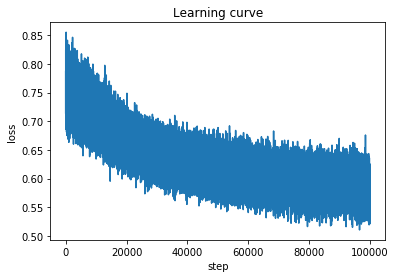

In [36]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

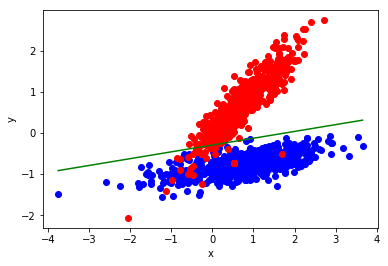

In [37]:
y_pred = - X[:, 0] * weights[0, 0] / weights[0, 1] - bias[0,0] / weights[0, 1] 

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');